# Flower Image Classifier

In this project, we train an image classifier to recognize different species of flowers. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

Firstly have our imports.

In [1]:
# Imports 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import json
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

from PIL import Image

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load the data

Here we use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data is included in the repository alongside this notebook and is split into three parts: training, validation, and testing. For the training we apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. We make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The relevant pre-trained networks were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets we normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
# Directory set-up
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# Define transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(20),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = validation_transforms

# Load the datasets with ImageFolder
train_image_datasets = datasets.ImageFolder(train_dir, transform=train_transforms)
validation_image_datasets = datasets.ImageFolder(valid_dir, transform=validation_transforms)
test_image_datasets = datasets.ImageFolder(test_dir, transform=test_transforms)

# Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_image_datasets, batch_size=64, shuffle=True) 
validloader = torch.utils.data.DataLoader(validation_image_datasets, batch_size=64, shuffle=True) 
testloader = torch.utils.data.DataLoader(test_image_datasets, batch_size=64, shuffle=True) 

### Label mapping

We also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This gives us a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the model

We use a pretrained models from `torchvision.models` to extract features and build (and train) a new feed-forward classifier using those features.

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) 
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

arch = 'vgg'
hidden = 512
output = 102
epochs = 3
learning_rate = 0.002
dropout = 0.25

In [6]:
def create_model(arch, device, hidden=256, output=102, dropout=0.1, learning_rate=0.005):
    """ 
    Take a pretrained model integrate a custom classifier layer 
    
    Parameters:
    arch (string): Architecture of pretrained network, either resnet or vgg 
    device (string): Cuda or CPU depending on availability
    hidden (int): Number of units in the hidden layer of the classifier
    output (int): The number of flower categories (here we have 102)
    dropout (float): Probability indicating dropout rate to be used in model
    learning_rate (float): Learning rate of model
    
    Outputs:
    model
    criterion
    optimizer
    
    """
    # Initialise resnet pretrained model
    if arch == 'resnet':
        model = models.resnet18(pretrained=True)
        
        # Freeze parameters by turning off gradients 
        for p in model.parameters():
            p.requires_grad = False

        # New Feedforward classifier 
        classifier = nn.Sequential(nn.Linear(512,hidden),
                                  nn.ReLU(),
                                  nn.Dropout(p=dropout),
                                  nn.Linear(hidden,output),
                                  nn.LogSoftmax(dim=1))
        model.fc = classifier
        optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

    
    elif arch == 'vgg':
        model = models.vgg16(pretrained=True)
        
        # Freeze parameters by turning off gradients 
        for p in model.parameters():
            p.requires_grad = False

        # New Feedforward classifier 
        model.classifier = nn.Sequential(nn.Linear(25088,hidden),
                                  nn.ReLU(),
                                  nn.Dropout(p=dropout),
                                  nn.Linear(hidden,output),
                                  nn.LogSoftmax(dim=1))
        optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)
        
    criterion = nn.NLLLoss()

    
    model.to(device);
        
        
    return model, criterion, optimizer
        

In [7]:
model, criterion, optimizer = create_model(arch, device, hidden, output, dropout, learning_rate)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:04<00:00, 111705400.22it/s]


In [8]:
def train_model(model, device, criterion, optimizer, epochs=3):
    
    
    epochs = epochs
    steps = 0
    running_loss = 0
    print_every = 10
    
    for epoch in range(epochs):
        for images, labels in trainloader:
            steps += 1
            images, labels = images.to(device), labels.to(device)

            # Zero out our gradients to forget the previous iteration
            optimizer.zero_grad()

            # Find our log probabilities
            logps = model.forward(images)
            # Loss function
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if steps % print_every == 0:
                # Validation loss counter
                valid_loss = 0
                accuracy = 0
                model.eval()

                with torch.no_grad():
                    for images, labels in validloader:
                        images, labels = images.to(device), labels.to(device)

                        logps = model.forward(images)
                        batch_loss = criterion(logps, labels)
                        valid_loss += batch_loss.item()

                        # Accuracy
                        ps = torch.exp(logps)
                        top_p, top_class = ps.topk(1, dim=1)
                        equals = top_class == labels.view(*top_class.shape)
                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

                print(f"Epoch {epoch+1}/{epochs}.. "
                      f"Train loss: {running_loss/print_every:.3f}.. "
                      f"Validation loss: {valid_loss/len(validloader):.3f}.. "
                      f"Validation accuracy: {accuracy/len(validloader):.3f}")
                running_loss = 0
                model.train()      


In [9]:
train_model(model, device, criterion, optimizer, epochs)

Epoch 1/3.. Train loss: 7.633.. Validation loss: 4.159.. Validation accuracy: 0.167
Epoch 1/3.. Train loss: 4.121.. Validation loss: 3.339.. Validation accuracy: 0.282
Epoch 1/3.. Train loss: 3.477.. Validation loss: 2.725.. Validation accuracy: 0.372
Epoch 1/3.. Train loss: 3.002.. Validation loss: 2.241.. Validation accuracy: 0.472
Epoch 1/3.. Train loss: 2.647.. Validation loss: 1.717.. Validation accuracy: 0.560
Epoch 1/3.. Train loss: 2.288.. Validation loss: 1.577.. Validation accuracy: 0.585
Epoch 1/3.. Train loss: 2.335.. Validation loss: 1.332.. Validation accuracy: 0.663
Epoch 1/3.. Train loss: 2.122.. Validation loss: 1.182.. Validation accuracy: 0.689
Epoch 1/3.. Train loss: 1.980.. Validation loss: 1.020.. Validation accuracy: 0.739
Epoch 1/3.. Train loss: 1.897.. Validation loss: 0.973.. Validation accuracy: 0.743
Epoch 2/3.. Train loss: 1.740.. Validation loss: 0.962.. Validation accuracy: 0.740
Epoch 2/3.. Train loss: 1.613.. Validation loss: 0.855.. Validation accuracy

## Testing your network

We test our model on images the network has never seen either in training or validation. This gives a good estimate for the model's performance on completely new images. 

In [10]:
def validation(model, device, loader=testloader):
    test_loss = 0
    test_accuracy = 0
    model.eval()

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            logps = model.forward(images)
            test_batch_loss = criterion(logps, labels)
            test_loss += test_batch_loss.item()

            # Accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

    print(f"Test loss: {test_loss/len(testloader):.3f}.. "
        f"Test accuracy: {test_accuracy/len(testloader):.3f}")
    

In [11]:
validation(model, device, testloader)

Test loss: 0.785.. Test accuracy: 0.795


## Save the checkpoint

Now we save our trained model so it can be loaded later for making predictions. We also save other things such as the mapping of classes to indices which you get from one of the image datasets: `train_image_datasets.class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training we would need the number of epochs and optimizer state, so these are included in the checkpoint.

In [12]:
# Save the checkpoint 

checkpoint = {
              'model_arch': arch,
              'n_hidden_units': hidden,
              'n_outputs': output,
              'epochs': epochs, # If we want to load model and keep training the number of epochs is necessary
              'learning_rate':learning_rate,
              'state_dict': model.state_dict(),
              'optimizer': optimizer.state_dict, # If continuing training the optimizer state is necessary
              'dropout': dropout,
              'class_to_idx': train_image_datasets.class_to_idx
             }

torch.save(checkpoint, 'checkpoint.pth')

## Loading the checkpoint

Write a function that can load a checkpoint and rebuild the model. That way we can come back to this project and keep working on it without having to retrain the network.

In [13]:
# Write a function that loads a checkpoint and rebuilds the model

def load_model(filepath):
    checkpoint = torch.load(filepath)
    
    dropout = checkpoint['dropout'] 
    learning_rate = checkpoint['learning_rate']
    
    # Use create model to initialise a model with identical architecture
    model, criterion, optimizer = create_model(checkpoint['model_arch'],
                                              device,
                                              checkpoint['n_hidden_units'],
                                              checkpoint['n_outputs'],
                                              checkpoint['dropout'],
                                              checkpoint['learning_rate'],
                                              )
    # Load in weights and biases from checkpoint
    model.load_state_dict(checkpoint['state_dict'])

    class_to_idx = checkpoint['class_to_idx']
    
    return model, criterion, optimizer, class_to_idx   


In [14]:
model, criterion, optimizer, class_to_idx = load_model('checkpoint.pth')

# Inference for classification

Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First we handle processing the input image such that it can be used in your network. 

## Image Preprocessing

Use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [15]:
def process_image(path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    image = Image.open(path)
    
    # Resize keeping aspect ratio constant and giving smaller side 256 length
    width, height = image.size
    aspect_ratio = width / height
    if width > height:
        image = image.resize( (round(256 * aspect_ratio), 256))
    else:
        image = image.resize( (256, round(256 / aspect_ratio)))

    # Crop center 224x224 of image
    width, height = image.size
    new_width, new_height = 224, 224
    
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2
    image = image.crop((round(left), round(top), round(right), round(bottom)))
    
    # NumPy array and colour channels
    np_image = np.array(image) / 255
    
    # Normalise
    np_image = (np_image - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
    # Colour channel the first dimension
    np_image = np_image.transpose((2,0,1))
    # From NumPy to Tensor
    tensor_img = torch.from_numpy(np_image).type(torch.FloatTensor)
    
    return tensor_img

To check our work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [16]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

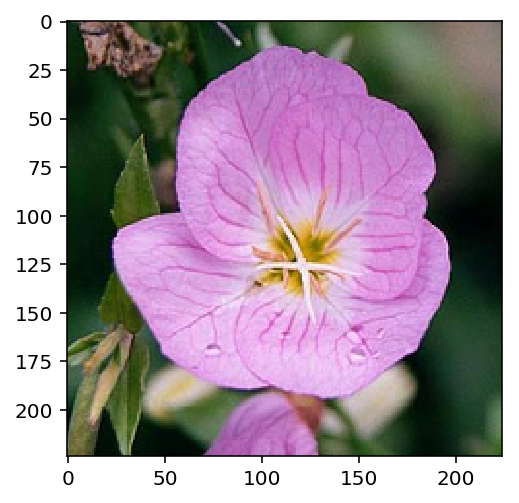

In [17]:
# Testing process image function by using imshow function
imshow(process_image(train_dir + '/1/image_06734.jpg'))

## Class Prediction

Once we can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. We want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. We need to convert from these indices to the actual class labels using `class_to_idx` which has been saved in our checkpoint. We make sure to invert the dictionary so to get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [18]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    image = process_image(image_path)
    
    
    class_to_idx_dict = {v: k for k, v in class_to_idx.items()}
    
    model.eval()
    model.cpu()
    with torch.no_grad():
        image.unsqueeze_(0)
        log_ps = model.forward(image)
        ps = torch.exp(log_ps)

        top_ps, top_classes = ps.topk(topk)
        top_ps, top_classes = top_ps[0].tolist(), top_classes[0].tolist()
        
        named_top_classes = []
        for key in top_classes:
            named_top_classes.append(class_to_idx_dict[key])

    return top_ps, named_top_classes
    

In [25]:
top_ps, named_top_classes = predict(test_dir + '/1/image_06743.jpg', model)
print(top_ps)
print(named_top_classes)

[0.9727226495742798, 0.015782225877046585, 0.0027206791564822197, 0.0017415634356439114, 0.0014395035104826093]
['1', '83', '76', '51', '91']


## Sanity Checking

Now that we have a trained model for predictions, we check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

We convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [20]:
# TODO: Display an image along with the top 5 classes
def plot_classification(image_path, model):
    
    image = process_image(image_path)
    top_ps, named_top_classes = predict(image_path, model)
    
    img = mpimg.imread(image_path)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(6,6), nrows=2)

    top_ps = np.flip(top_ps, axis = 0)
    named_top_classes = np.flip(named_top_classes, axis = 0)
    labels = [cat_to_name[i] for i in named_top_classes]
    
    ax1.imshow(img)
    ax1.set_title(cat_to_name[image_path.split('/')[-2]])
    ax1.axis('off')
    
    ax2.barh(np.arange(len(top_ps)), top_ps)
    ax2.set_aspect(0.2)
    ax2.set_yticks(np.arange(5))
    ax2.set_yticklabels(labels)
    ax2.set_xlim(0, 1)
    ax2.set_title('Class Probability')

    plt.tight_layout()
    

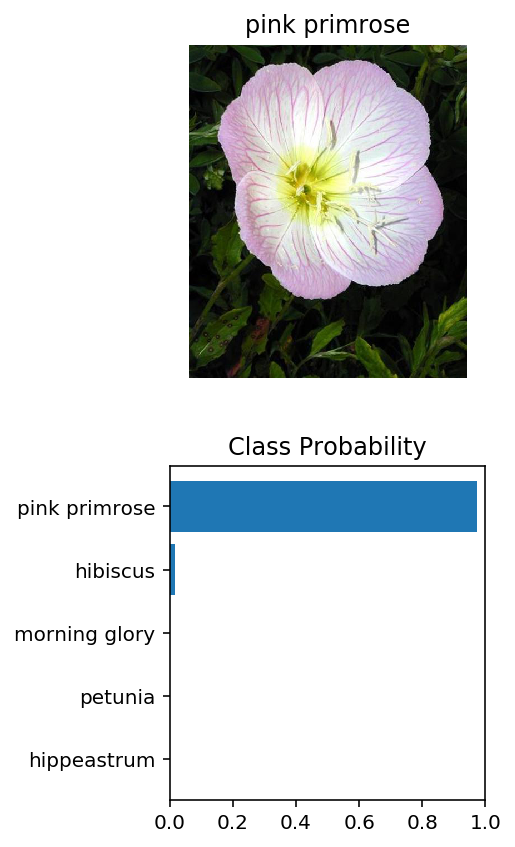

In [21]:
plot_classification(test_dir + "/1/image_06743.jpg", model)

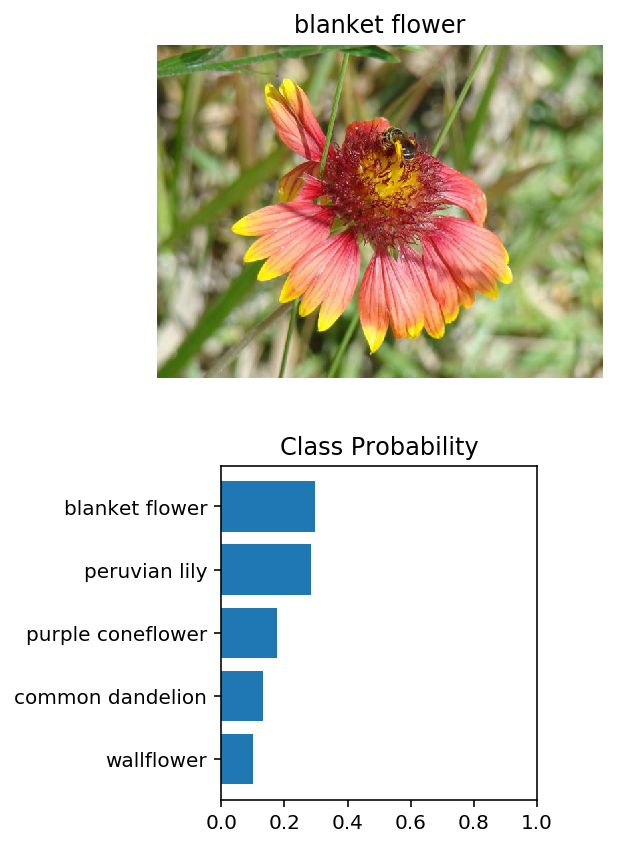

In [22]:
plot_classification(test_dir + "/100/image_07902.jpg", model)